In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualizar los conjuntos de datos

Graficar la tasa de deposición de polvo del conjunto de datos empíricos en las ubicaciones de medición y los datos simulados en la cuadrícula global.

In [2]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [3]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# Utiliza GeoPandas para leer un archivo que contiene datos geoespaciales del mapa mundial. 

## Función para graficar el mapa de deposición de polvo

* Esta es una función que toma como entrada un DataFrame df que contiene los datos de deposición de polvo, así como otros parámetros necesarios para generar y personalizar el mapa.

* Dentro de la función, se convierte el DataFrame en un objeto GeoDataFrame utilizando la biblioteca GeoPandas. Esto se hace para que los datos puedan ser trazados en un mapa utilizando las coordenadas de longitud y latitud.

* Se crea una figura y un eje para el gráfico utilizando Matplotlib.

* Se establecen los límites y las marcas para los ejes X e Y del gráfico.

* Se traza el mapa mundial utilizando los límites geográficos cargados previamente.

* Se trazan los datos de deposición de polvo en el mapa utilizando los puntos del GeoDataFrame. La columna especificada en label_str se utiliza para colorear los puntos en el mapa.

* Se agregan etiquetas y título al gráfico.

* Finalmente, el gráfico se guarda como un archivo PDF con el nombre especificado en name_to_save y se muestra en la pantalla.

In [4]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Genera un mapa de deposición de polvo basado en el dataframe proporcionado.

    Parámetros:
    - df (pandas DataFrame): El dataframe que contiene los datos de deposición de polvo.
    - title (str): El título que se mostrará en el gráfico.
    - name_to_save (str): El nombre de archivo para guardar el mapa generado.
    - label_str (str, opcional): El nombre de la columna en el dataframe para usar como etiqueta en el gráfico. Por defecto es 'log_dep'.
    - measure_units (str, opcional): Las unidades de medida para el flujo de polvo. Por defecto es 'Flujo de polvo log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, opcional): El valor límite para la barra de colores en el gráfico. Por defecto es 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Establecer límites y marcas
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Graficar mapa mundial
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Graficar el GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Establecer etiquetas y título
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Guardar y mostrar el gráfico
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return

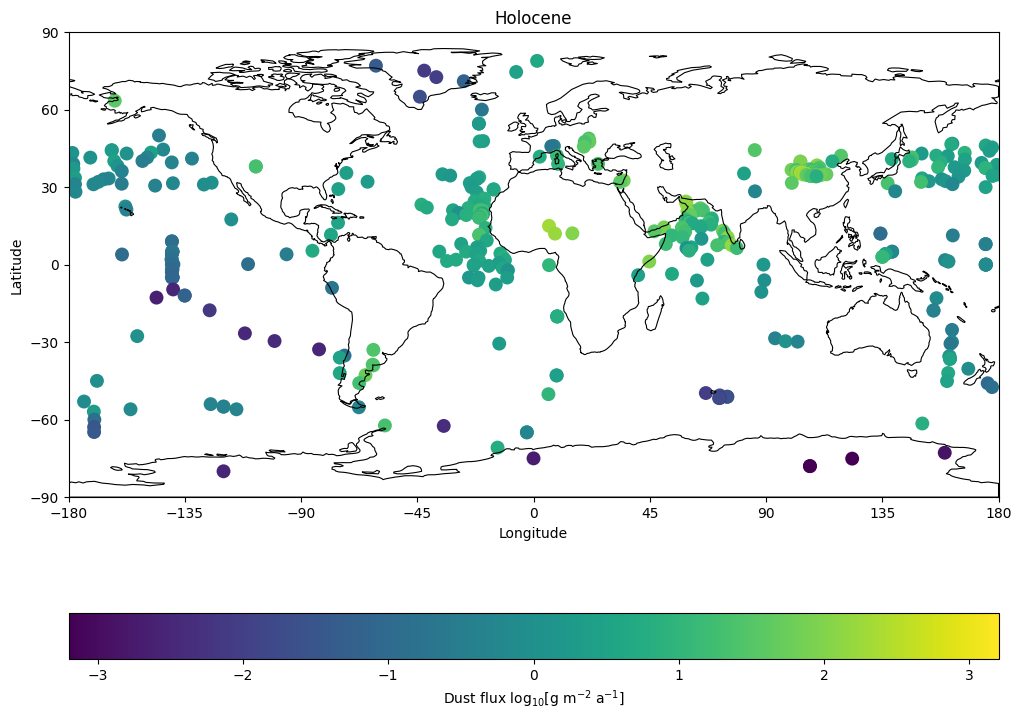

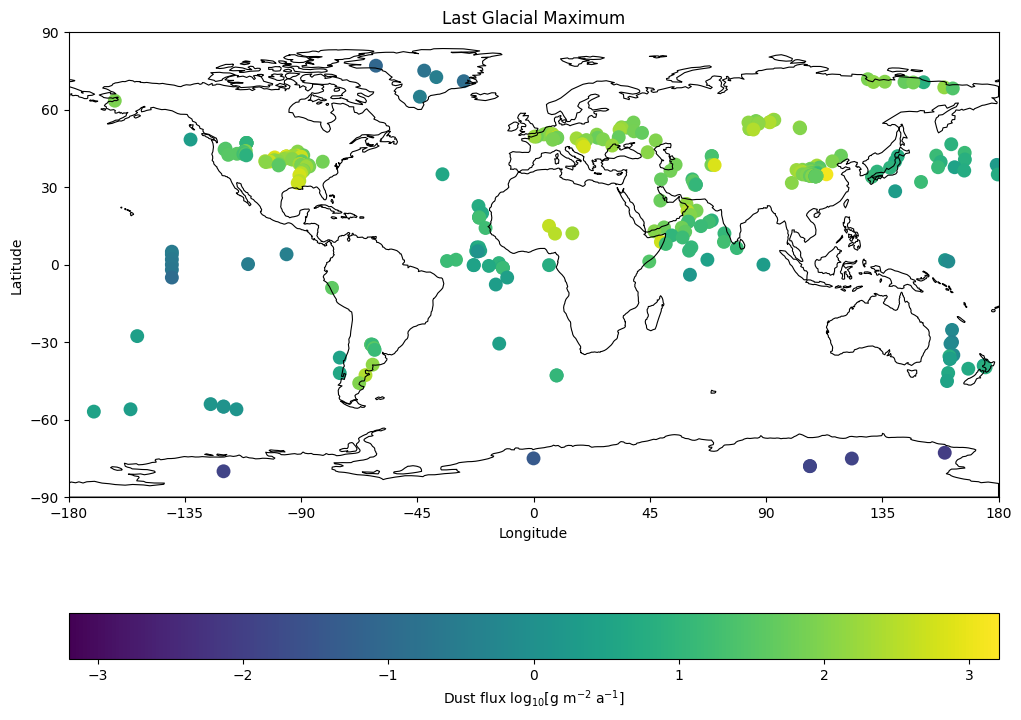

In [5]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Crear y visualizar la cuadrícula global

La cuadrícula global para las predicciones consiste en un espaciado de 3 grados.

In [6]:
# Creación de coordenadas de longitud y latitud
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

# Creación de una cuadrícula de coordenadas de longitud y latitud
xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)

# Creación de pares de coordenadas X e Y
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])

# Creación de un GeoDataFrame y un DataFrame de Pandas
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

In [7]:
# DataFrame resultante
df_global_grid

,lon,lat
0,-180.0,-90.0
1,-177.0,-90.0
2,-174.0,-90.0
3,-171.0,-90.0
4,-168.0,-90.0
...,...,...
7376,168.0,90.0
7377,171.0,90.0
7378,174.0,90.0
7379,177.0,90.0


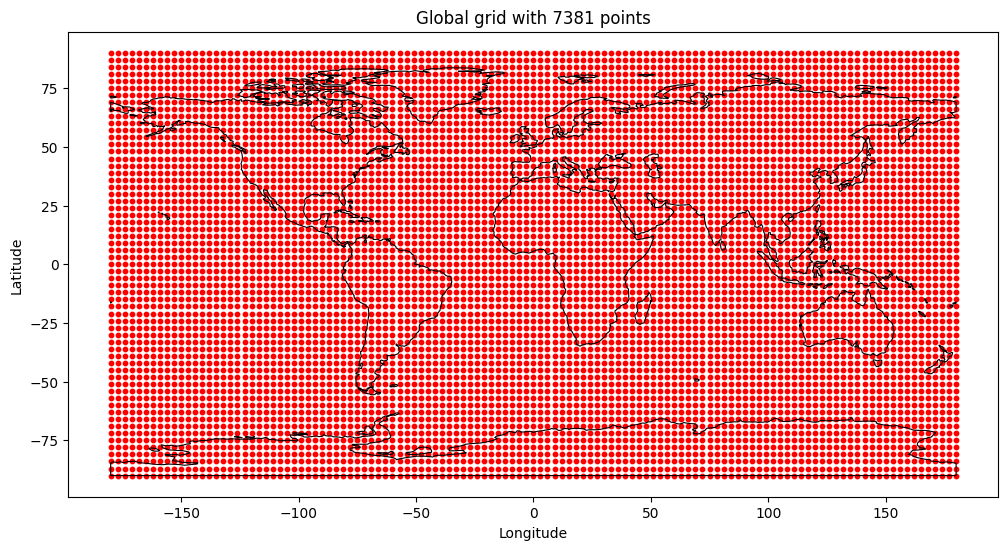

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analizar la tasa de deposición global con los vecinos más cercanos

La tasa de deposición de polvo se estimará promediando los valores de los $k$ vecinos más cercanos.

## Distancia Euclidiana

Distancia en línea recta entre dos puntos en el espacio euclidiano.

In [9]:
def distance_euclidean(x, y):
    """
    Calcular la distancia euclidiana entre dos puntos.

    Parámetros:
    x, y: Iterable
        Vectores para la ubicación 2D de los dos puntos.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

## Distancia Geodésica

Una línea geodésica es el camino más corto entre dos puntos en una superficie curva, como la Tierra.

La distancia geodésica entre dos puntos en una esfera se calcula utilizando la longitud y la latitud de ambos puntos.

In [10]:
def distance_geodesic(x, y):
    """
    Calcular la distancia geodésica entre dos puntos en la Tierra.

    Parámetros:
    x, y: Iterable
        Vectores para la ubicación 2D de los dos puntos.
        Pares de coordenada de longitud y latitud en grados.
    """

    R = 6371 # Radio de la Tierra en kilometros
    longitud_1, latitud_1 = x
    longitud_2, latitud_2 = y

    # Transformamos las coordenadas de grados a radianes
    longitud_1 = np.radians(longitud_1)
    longitud_2 = np.radians(longitud_2)
    latitud_1 = np.radians(latitud_1)
    latitud_2 = np.radians(latitud_2)

    # Cálculo de la distancia
    parte_1 = np.sin(latitud_1) * np.sin(latitud_2)
    parte_2 = np.cos(latitud_1) * np.cos(latitud_2) * np.cos(longitud_2 - longitud_1)
    
    distance = R * np.arccos(parte_1 + parte_2)

    return distance

## Explicación Metodo k-nn, (vecinos más cercanos)    
*Explicación del método pedida a chatgpt*.


"Este método funciona de la siguiente manera:

* Supongamos que tienes datos de muchos otros puntos en el mapa, junto con la cantidad de polvo en cada uno de ellos.

* Cuando tienes un nuevo punto para el que quieres hacer una estimación, buscas los puntos en el mapa que están más cerca de este nuevo punto.

* Luego, miras cuánto polvo hay en esos puntos cercanos y haces una adivinanza basada en eso. Por ejemplo, podrías promediar la cantidad de polvo en esos puntos cercanos y usar ese promedio como tu estimación para el nuevo punto.

La "k" en "k-NN" se refiere al número de vecinos que miras. Por ejemplo, si k es 5, mirarías los 5 puntos más cercanos al nuevo punto y usarías la información de esos 5 puntos para hacer tu estimación."

In [11]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Realizar una estimación de los k vecinos más cercanos.

    Parámetros:
    df : pandas.DataFrame
        La base de datos.
    x : Iterable
        Ubicación para la estimación.
    k : int
        El número de vecinos a considerar.
    dist : str
        El tipo de definición de distancia.
    """
    
    # Se selecciona la función adecuada para calcular la distancia entre puntos
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    # Cálculo de las distiancias desde 'x' hasta los vecinos cercanos dependiendo de la función de distancia a usar
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)  # Se ordenan las distancias y se obtienen los índices de los k puntos más cercanos
    nearest_points = sorted_indices[:k] # Contiene los índices de los k vecinos más cercanos
    
    values_neighbours = df.loc[nearest_points, "log_dep"] 
    estimation = np.average(values_neighbours) # Se calcula el promedio de estos valores, que se utiliza como estimación final
    
    return estimation

La variable "estimación" representa la cantidad de polvo que se estima que hay en el nuevo punto del mapa.

# Estimaciones

In [12]:
# Elija el número de vecinos a incluir en la estimación
n_neighbours = 5

## Estimación Euclidiana

Se realiza la estimación de la cantidad de polvo en cada punto de la cuadrícula global para dos períodos de tiempo diferentes: Holoceno (período interglacial) y Último Máximo Glacial (LGM), utilizando el método de los vecinos más cercanos con distancia euclidiana.

In [13]:
# Se inicializan dos columnas de longitud igual al número de puntos en la cuadrícula global
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

# Se realiza un bucle a través de cada fila del df_global_grid, que contiene la cuadrícula global de puntos
for index, row in df_global_grid.iterrows():

    # Se obtiene la ubicación del punto en términos de longitud y latitud
    point_for_estimation = (row["lon"], row["lat"])

    # Se utiliza la función nearest_neighbour_estimation para estimar la cantidad de polvo en ese punto en el Holoceno como para el LGM
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

# Se agregan las columnas al DataFrame
df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

## Estimación Geodésica

Se realiza la estimación de la cantidad de polvo en cada punto de la cuadrícula global para dos períodos de tiempo diferentes: Holoceno (período interglacial) y Último Máximo Glacial (LGM), utilizando el método de los vecinos más cercanos con distancia Geodésica.

In [14]:
# Se inicializan dos columnas de longitud igual al número de puntos en la cuadrícula global
estimations_holocene_geodesica = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesica = np.repeat(np.inf, len(df_global_grid))

# Se realiza un bucle a través de cada fila del df_global_grid, que contiene la cuadrícula global de puntos
for index, row in df_global_grid.iterrows():

    # Se obtiene la ubicación del punto en términos de longitud y latitud
    point_for_estimation = (row["lon"], row["lat"])
    
    # Se utiliza la función nearest_neighbour_estimation para estimar la cantidad de polvo en ese punto en el Holoceno como para el LGM
    estimations_holocene_geodesica[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geodesica[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

# Agregar las nuevas columnas al df_global_grid
df_global_grid["est_hol_geodesica"] = estimations_holocene_geodesica
df_global_grid["est_lgm_geodesica"] = estimations_lgm_geodesica


In [15]:
# DataFrame actualizado
df_global_grid

,lon,lat,est_hol,est_lgm,est_hol_geodesica,est_lgm_geodesica
0,-180.0,-90.0,-0.736623,-0.111441,-3.034526,-1.804872
1,-177.0,-90.0,-0.736623,-0.111441,-3.034526,-1.804872
2,-174.0,-90.0,-0.736623,-0.175193,-3.034526,-1.804872
3,-171.0,-90.0,-0.736623,-0.175193,-3.034526,-1.804872
4,-168.0,-90.0,-0.740268,-0.175193,-3.034526,-1.804872
...,...,...,...,...,...,...
7376,168.0,90.0,0.388114,1.583464,-0.889438,-0.272050
7377,171.0,90.0,0.388114,1.583464,-0.889438,-0.272050
7378,174.0,90.0,0.388114,1.583464,-0.889438,-0.272050
7379,177.0,90.0,0.388114,1.583464,-0.889438,-0.272050


# **Mapas**

# Mapa Euclidiana

Mapa de la estimación de cantidad de polvo mediante la utilización de la distancia euclidiana.

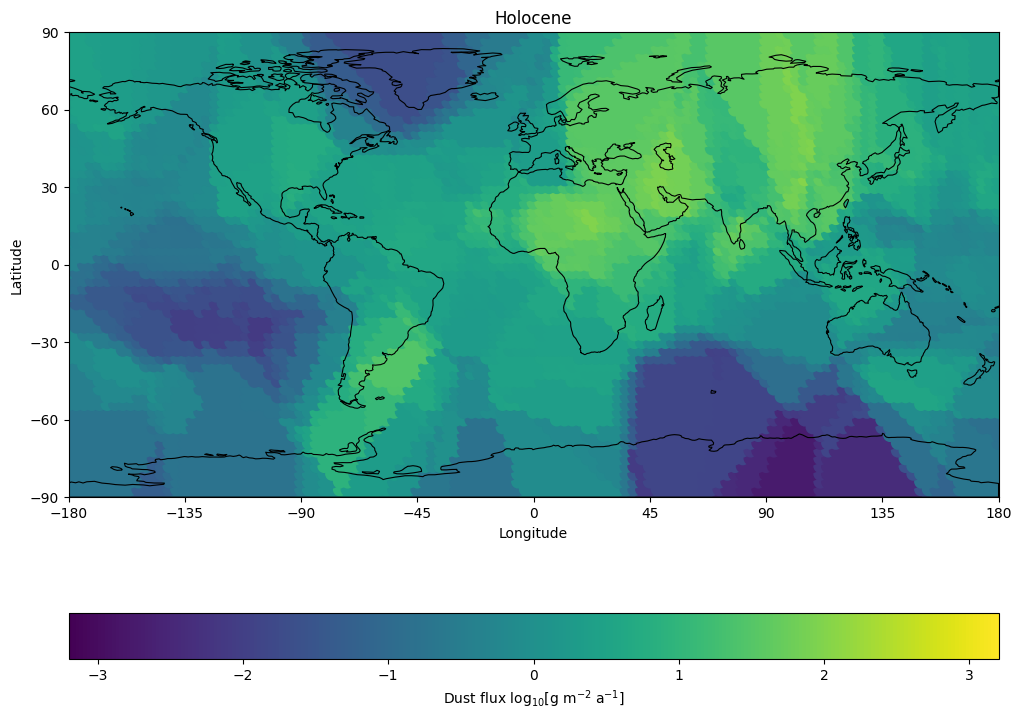

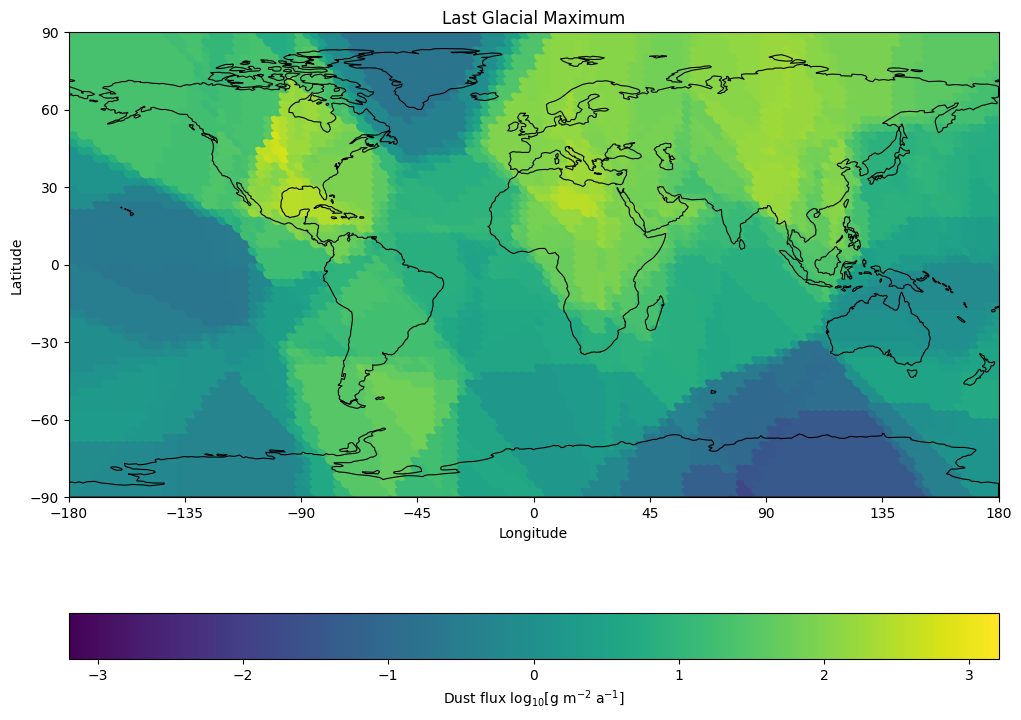

In [16]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

## Mapa Geodésica

Mapa de la estimación de cantidad de polvo mediante la utilización de la distancia geodésica.

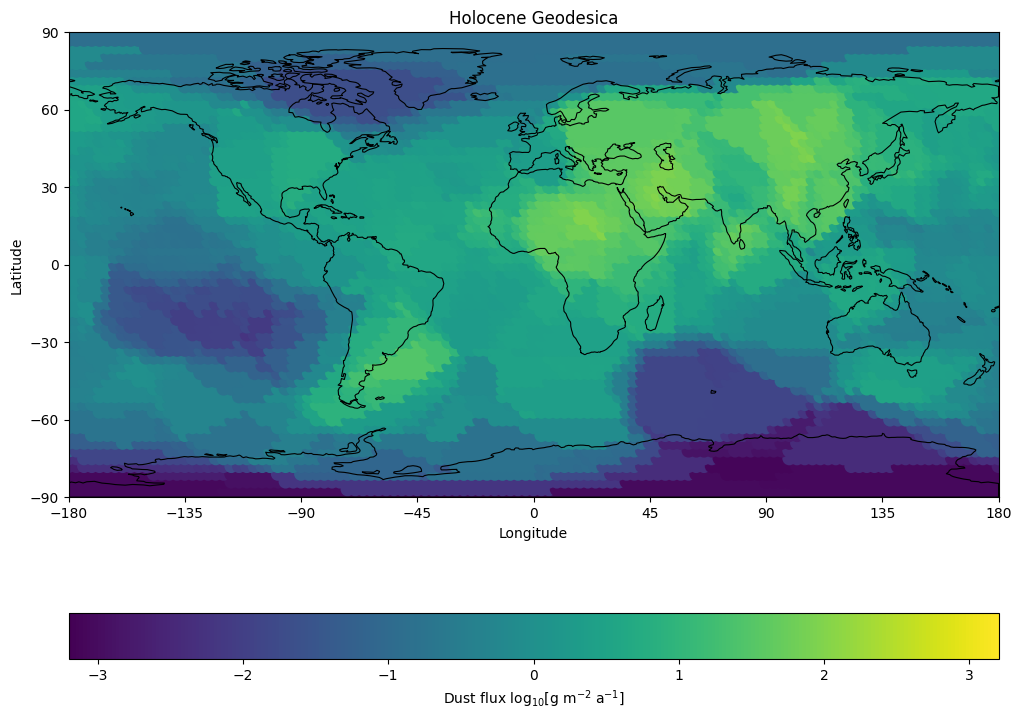

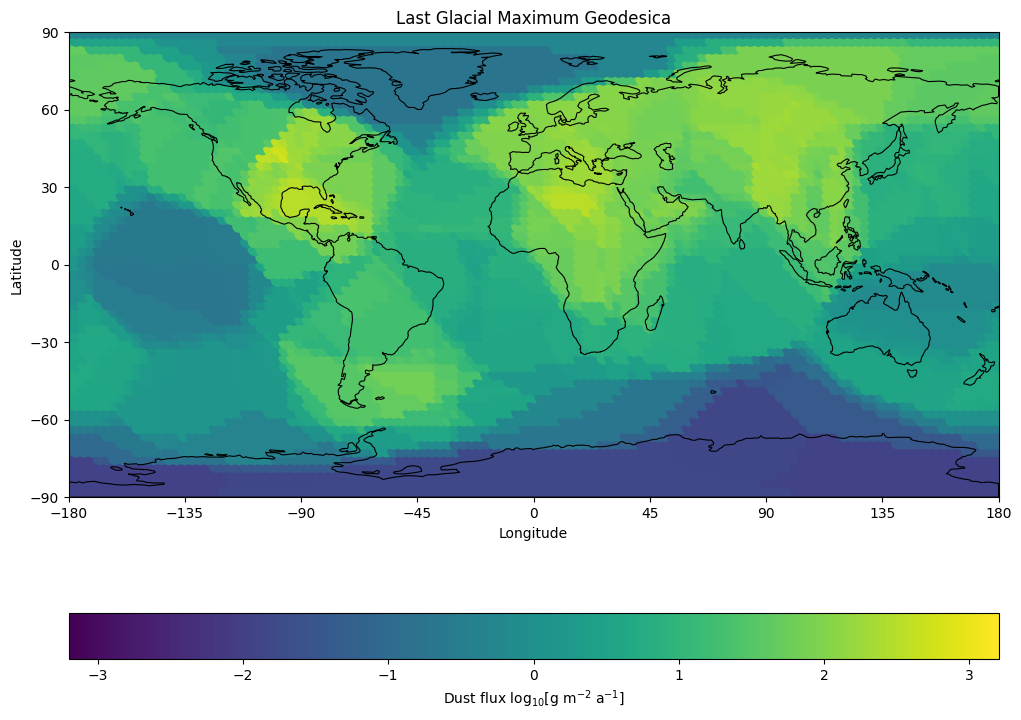

In [17]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene Geodesica',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_GEODESIC',
                         label_str='est_hol_geodesica')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum Geodesica',
                         name_to_save='ESTIMATION_MAP_LGM_GEODESIC',
                         label_str='est_lgm_geodesica')


# Diferencia entre los métodos

Se calculan las diferencias entre los métodos para el periodo Holoceno y para el LGM. Luego se agregan dos columnas al DataFrame con los valores resultantes de esta diferencia.

In [18]:
# Calcular la diferencia entre las estimaciones de los dos métodos
df_global_grid['diferencia'] = df_global_grid['est_hol_geodesica'] - df_global_grid['est_hol']
df_global_grid['diferencia_lgm'] = df_global_grid['est_lgm_geodesica'] - df_global_grid['est_lgm']


In [19]:
df_global_grid

,lon,lat,est_hol,est_lgm,est_hol_geodesica,est_lgm_geodesica,diferencia,diferencia_lgm
0,-180.0,-90.0,-0.736623,-0.111441,-3.034526,-1.804872,-2.297903,-1.693431
1,-177.0,-90.0,-0.736623,-0.111441,-3.034526,-1.804872,-2.297903,-1.693431
2,-174.0,-90.0,-0.736623,-0.175193,-3.034526,-1.804872,-2.297903,-1.629679
3,-171.0,-90.0,-0.736623,-0.175193,-3.034526,-1.804872,-2.297903,-1.629679
4,-168.0,-90.0,-0.740268,-0.175193,-3.034526,-1.804872,-2.294258,-1.629679
...,...,...,...,...,...,...,...,...
7376,168.0,90.0,0.388114,1.583464,-0.889438,-0.272050,-1.277551,-1.855513
7377,171.0,90.0,0.388114,1.583464,-0.889438,-0.272050,-1.277551,-1.855513
7378,174.0,90.0,0.388114,1.583464,-0.889438,-0.272050,-1.277551,-1.855513
7379,177.0,90.0,0.388114,1.583464,-0.889438,-0.272050,-1.277551,-1.855513


# Visualización de las diferencias

## Interpretación de signos de las diferencias:

El signo de las diferencias indica la dirección de la diferencia entre las dos estimaciones: 

* Si la diferencia es **negativa**, significa que la estimación geodésica es menor. En otras palabras, en un punto dado "x", la cantidad de polvo estimada utilizando la distancia geodésica es menor que la cantidad estimada utilizando la distancia euclidiana.

* Si la diferencia es **positiva**, significa que la estimación geodésica es mayor. Esto implica que, en un punto específico "x", la cantidad de polvo estimada utilizando la distancia geodésica es mayor que la estimación resultante de la distancia euclidiana.

In [20]:
# Este mapa de calor utilizó la estructura de la función lot_dust_deposition_map
# Fue modificado para que accediera a las columnas de las diferencias con la ayuda de chatgpt
def mapa_calor_diferencia(df, titulo, nombre_a_guardar, diff_column, measure_units='Diferencia de polvo', limit_bar=3.2):
    """
    Parámetros:
    - df (pandas DataFrame): El dataframe que contiene las diferencias de polvo.
    - titulo (str): El título que se mostrará en el gráfico.
    - nombre_a_guardar (str): El nombre de archivo para guardar el mapa generado.
    - diff_column (str): El nombre de la columna en el dataframe que contiene las diferencias.
    - measure_units (str, opcional): Las unidades de medida para las diferencias de polvo. Por defecto es 'Diferencia de polvo'.
    - limit_bar (float, opcional): El valor límite para la barra de colores en el gráfico. Por defecto es 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Establecer límites y marcas
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Graficar mapa mundial
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Graficar el GeoDataFrame
    df_dust_geopandas.plot(column=diff_column,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='coolwarm',  # se cambia el color del mapa a coolwarm para diferencias positivas y negativas
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005)

    # Establecer etiquetas y título
    ax.set(xlabel='Longitude', ylabel='Latitude', title=titulo)

    # Guardar y mostrar el gráfico
    plt.savefig(f"{nombre_a_guardar}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return

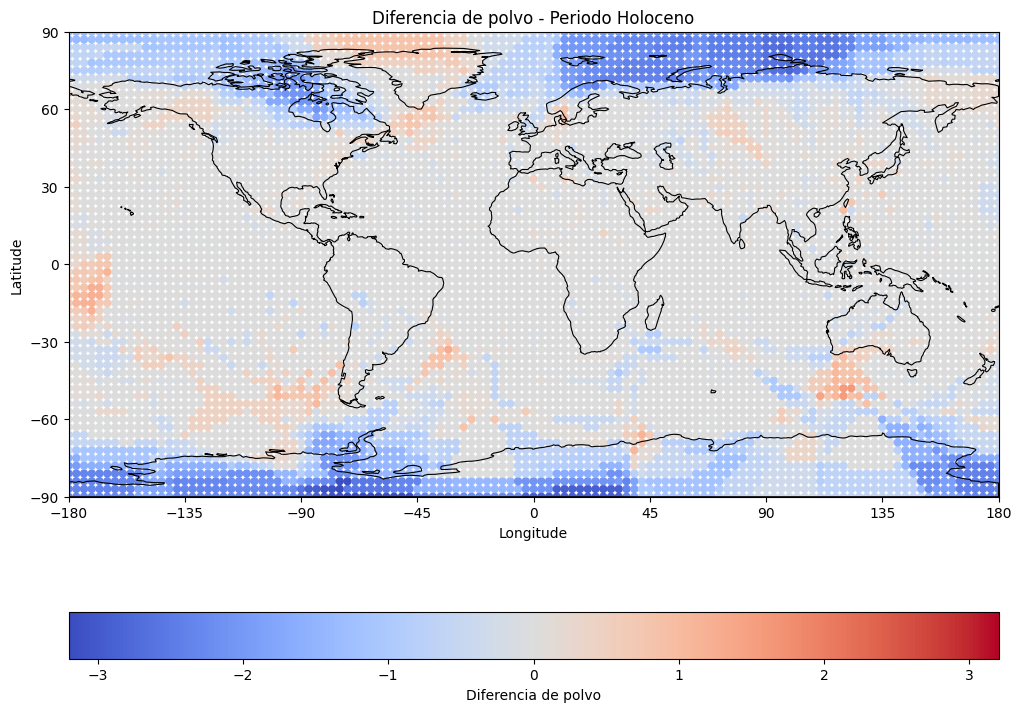

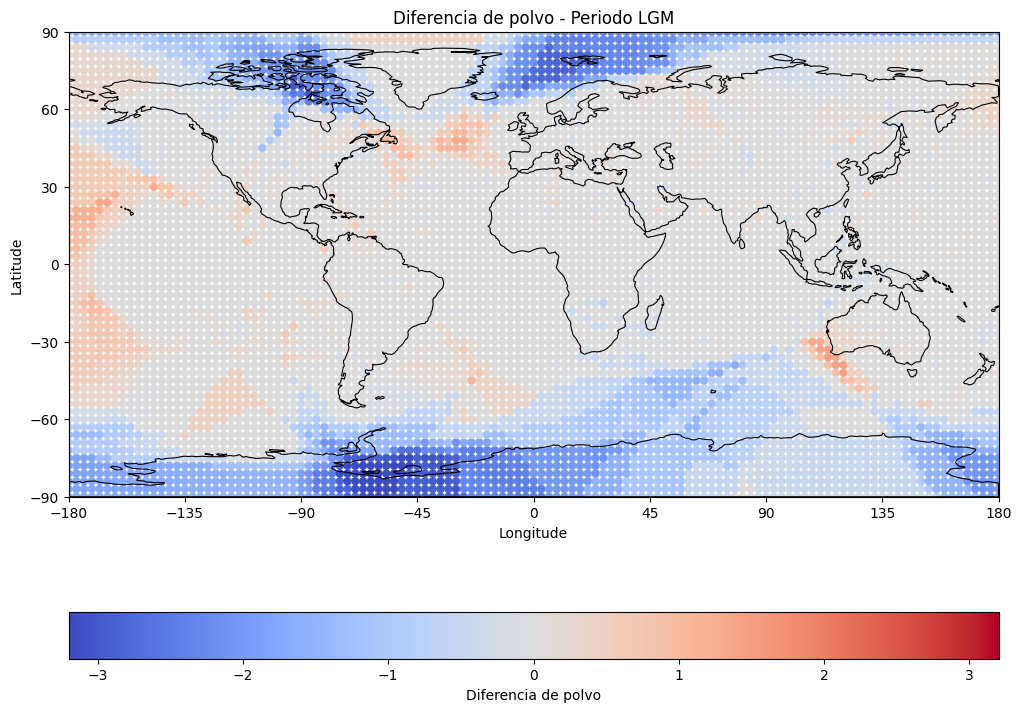

In [21]:
# Mapa de calor para el periodo del Holoceno
mapa_calor_diferencia(df=df_global_grid, 
             titulo='Diferencia de polvo - Periodo Holoceno', 
             nombre_a_guardar='mapa_calor_holoceno', 
             diff_column='diferencia')

# Mapa de calor para el periodo del lgm
mapa_calor_diferencia(df=df_global_grid, 
             titulo='Diferencia de polvo - Periodo LGM', 
             nombre_a_guardar='mapa_calor_lgm', 
             diff_column='diferencia_lgm')


Representamos la diferencia entre las estimaciones de polvo utilizando las distancias euclidiana y geodésica mediante mapas de calor, en donde:

* **Azul**: Indica una diferencia **negativa**, lo que significa que la estimación geodésica es menor que la estimación euclidiana. En otras palabras, la estimación geodésica calculó una menor cantidad de polvo en esa ubicación en comparación con la estimación euclidiana.

* **Rojo**: Indica una diferencia **positiva**, lo que significa que la estimación geodésica es mayor que la estimación euclidiana. Esto podría interpretarse como que la estimación geodésica calculó una mayor cantidad de polvo en esa ubicación en comparación con la estimación euclidiana.

* **Colores neutros o tenues**: Indican que las diferencias entre las estimaciones son mínimas. Esto puede significar que tanto la estimación geodésica como la euclidiana calcularon cantidades de polvo similares en esa ubicación.

# Análisis de las diferencias en los resultados de polvo

**¿Por qué se presentan diferencias más grandes en una parte que en otra parte del mundo?**

Los datos sobre la cantidad de polvo en distintas partes del mundo nos muestran que hay diferencias notables entre los métodos de cálculo geodésico y euclidiano. Estas diferencias pueden surgir por varios motivos que afectan cómo estimamos la cantidad de polvo en la tierra.

En partícular, los polos son regiones con climas extremos, las condiciones atmosféricas y la distribución del polvo son más complicadas de modelar con precisión, puesto que son lugares no tan poblados.

En consecuencia, resulta que la disponibilidad y calidad de los datos utilizados para hacer estas estimaciones no son uniformes en todo el mundo. Esto se puede evidenciar al ver los mapas de deposición de polvo, en ambos se observa que hay muchos más puntos cerca del ecuador que en los polos. Esto indica que tenemos más datos en las áreas más pobladas, lo que nos permite hacer estimaciones más precisas. Por el contrario, en áreas con pocos datos (los polos), las estimaciones pueden ser menos precisas porque no tenemos suficiente información. Esto genera diferencias más grandes entre los resultados de los distintos métodos, ya que los puntos de referencia más cercanos pueden estar más lejos en estas áreas menos pobladas.

**¿Cuál método es más fidedigno en los polos sur y norte?**

En los polos, donde el relieve se presenta con mayor prominencia, la distancia euclidiana puede no proporcionar una representación precisa de las distancias reales entre puntos. Esto se debe a que este método considera el terreno como una superficie plana, ignorando la estructura sobresaliente de la geografía polar. Como resultado, es posible que subestimemos la cantidad de polvo en estas áreas al utilizar la distancia euclidiana.

Además, en estos polos donde la densidad de datos es menor debido a su ubicación remota, los puntos de referencia más cercanos para realizar las estimaciones suelen encontrarse relativamente lejos. Esta distancia extendida entre los puntos de datos puede generar resultados imprecisos al utilizar el método euclidiano, ya que este no tiene en cuenta la curvatura de la Tierra.

En otras palabras, mientras más alejados estén los datos de referencia del punto que se desea estimar, más pronunciada será la diferencia entre las distancias planas y geodésicas. Si los puntos de datos de referencia estuvieran más cerca del punto a estimar, es probable que la distorsión en los resultados utilizando el método euclidiano fuera menor.

"*La diferencia entre las distancias planar y geodésica aumenta proporcionalmente a medida que aumenta la distancia respecto al origen. Si está trabajando en una geografía pequeña, como una ciudad o un condado, la diferencia entre las distancias planar y geodésica es proporcionalmente menor que si está trabajando a la escala de un país*."

Fragmento extraído de https://pro.arcgis.com/es/pro-app/latest/tool-reference/spatial-analyst/geodesic-versus-planar-distance.htm

Por lo tanto, considerando la necesidad de una precisión mayor en áreas donde los datos están más distantes dentro de la esfera terrestre, el método más fiable para estimaciones en los polos es el método geodésico. Este método tiene en cuenta la verdadera forma esférica de la Tierra y proporciona cálculos más precisos en estas regiones de relieve prominente y de escasez de datos.

**¿Cuál método es más fidedigno en longitud 180°?**

En la longitud 180°, también conocida como meridiano 180, se observan diferencias en las estimaciones entre los dos métodos tanto en el período holoceno como en el LGM. En general, las discrepancias son menores en las zonas cercanas al ecuador terrestre, donde la densidad de datos para las estimaciones es mayor. Sin embargo, en las proximidades de los polos, específicamente cerca de las latitudes -60° y 60°, se aprecian mayores distorsiones en las estimaciones.

Particularmente en el período LGM, caracterizado por una disponibilidad de datos más limitada, las discrepancias en las estimaciones en la longitud 180° se extienden más allá de las áreas polares. Esto se evidencia al observar el mapa de dispersión de polvo de este período, donde se encuentran discrepancias incluso en regiones centrales, lejos de los polos. La falta generalizada de datos en este período contribuye a esta situación. En este contexto, el método geodésico emerge como más confiable debido a su capacidad para analizar superficies no planas, lo que resulta especialmente útil en áreas con una cobertura de datos limitada.

Para el período holoceno, donde la cantidad de datos disponibles es mayor en comparación con el LGM, las diferencias entre los métodos no son tan pronunciadas en la longitud 180°. Por lo tanto, se podría argumentar que ambos métodos podrían ser suficientemente precisos en estas condiciones. Sin embargo, dado el contexto de análisis de distancias en una superficie esférica como la Tierra, se inclina ligeramente la balanza hacia el método geodésico, que considera mejor la curvatura del planeta.

En resumen, en la longitud 180°, el método geodésico es más fiable, especialmente en el período LGM debido a la escasez de datos. Para el período holoceno, ambos métodos pueden ser adecuados, pero se prefiere el método geodésico dada su capacidad para modelar superficies no planas.

**¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?**

Las principales diferencias entre los resultados para el Holoceno y el LGM se manifiestan no solo en la cantidad de polvo distribuido por la Tierra, sino también en la distribución geográfica y las distancias que abarcan estas concentraciones de polvo. En los mapas de dispersión de polvo del período LGM, se observa una mayor concentración de polvo en el continente asiático y europeo, donde los datos alcanzan valores cercanos a 3 en la escala de la leyenda del mapa. Esto sugiere la presencia de condiciones ambientales que favorecieron una mayor generación o acumulación de polvo en esas regiones durante el LGM. 

Por otro lado, en el Holoceno, las cantidades de polvo parecen estar más distribuidas, con valores que fluctúan entre -1 y 1 en la escala de la leyenda del mapa. Esta distribución más uniforme puede indicar una menor variabilidad en las condiciones ambientales y climáticas durante el Holoceno en comparación con el LGM.

Además, las diferencias en las distancias entre puntos de datos pueden influir en la cantidad de polvo estimada en cada región, ya que las distancias geodésicas pueden tener en cuenta la curvatura de la Tierra y proporcionar estimaciones más precisas en áreas con una cobertura de datos más lejanas.

**¿Cómo elegir el número de vecinos cercanos?**

En áreas con una densidad de datos más alta, como las zonas centrales cerca del ecuador, puede ser beneficioso utilizar un número mayor de vecinos cercanos. Esto se debe a que hay una mayor disponibilidad de puntos de datos cercanos que pueden proporcionar una estimación más precisa de las características del área circundante.

Sin embargo, en áreas remotas o distantes, como los polos, donde la densidad de datos es menor y los puntos de datos cercanos pueden estar más dispersos, utilizar un número alto de vecinos cercanos puede no ser óptimo. Esto se debe a que los vecinos cercanos pueden estar muy separados entre sí, lo que resulta en una estimación menos precisa de las características del área en cuestión. En estos casos, es preferible utilizar un número menor de vecinos cercanos que estén lo suficientemente cerca como para proporcionar una representación precisa de las condiciones locales, pero no tan lejos como para introducir errores significativos en la estimación.